# Measuring Runtime of Regional Effect Plots  

This notebook analyzes the runtime $T(\cdot)$ of Regional Effect plots, which depends on:  

- **$t_f$**: Time to evaluate the black-box function $f$.  
- **$N$**: Number of instances in $X$.  
- **$D$**: Number of features in $X$.  
- **$K$**: Number of points for centering the feature effect plot.  
- **$M$**: Number of evaluation points.  

The main factors affecting runtime are $t_f$, $N$, and $D$.  

### Runtime Breakdown  

1. **Global heterogeneity computation** ($T_{global}$):  
   - Done once for the entire dataset.  
   - Stores intermediate values for reuse.  
   - Runtime:  
     - $T_{global} = \mathcal{O}(N) + \mathcal{O}(t_f)$ for PDP and d-PDP.  
     - $T_{global} = \mathcal{O}(t_f)$ for RHALE.  

2. **Cart-based subregion heterogeneity** ($T_{cart}$):  
   - Iterates over $D-1$ features.  
   - Evaluates $P$ possible conditioning positions.  
   - Recursively splits the dataset up to depth $L$.  
   - Heterogeneity is computed without re-evaluating $f$, only splitting and indexing instances.  

   $$ T_{cart} = (D-1)PL \cdot T(N) $$  

### Total Runtime  

$$
T(t_f, N, D) \approx T_{global} + T_{cart} \approx \mathcal{O}(N) + \mathcal{O}(t_f) + \mathcal{O}(DPLN)
$$  

Runtime is **linear in all key variables**. When computing for all features, it scales as $D^2$.  

Now, let's test this in practice!

In [1]:
import effector
import numpy as np
import timeit
import time
import matplotlib.pyplot as plt
np.random.seed(21)

In [2]:
def return_predict(t):
    def predict(x):
        time.sleep(t)
        model = effector.models.DoubleConditionalInteraction()
        return model.predict(x)
    return predict

def return_jacobian(t):
    def jacobian(x):
        time.sleep(t)
        model = effector.models.DoubleConditionalInteraction()
        return model.jacobian(x)
    return jacobian

In [3]:
def measure_time(method_name, features):
    fit_time_list, eval_time_list = [], []
    X = np.random.uniform(-1, 1, (N, D))
    xx = np.linspace(-1, 1, M)
    axis_limits = np.array([[-1] * D, [1] * D])

    method_map = {
        "pdp": effector.RegionalPDP,
        "d_pdp": effector.RegionalDerPDP,
        "ale": effector.RegionalALE,
        "rhale": effector.RegionalRHALE,
        "shap_dp": effector.RegionalShapDP
    }

    for _ in range(repetitions):
        # general kwargs
        method_kwargs = {"data": X, "model": model, "axis_limits": axis_limits, "nof_instances":"all"}
        fit_kwargs = {"features": features, "centering": True, "points_for_centering": K, "max_depth": 2}

        # specialize kwargs per method
        if method_name in ["d_pdp", "rhale"]:
            method_kwargs["model_jac"] = model_jac
        if method_name in ["rhale", "ale"]:
            fit_kwargs["binning_method"] = effector.binning_methods.Fixed(nof_bins=20, min_points_per_bin=0.)
            fit_kwargs.pop("centering")
            fit_kwargs.pop("points_for_centering")

        # init
        method = method_map[method_name](**method_kwargs)

        # fit
        tic = time.time()
        method.fit(**fit_kwargs)
        fit_time_list.append(time.time() - tic)

        # eval
        tic = time.time()
        for feat in features:
            eval_kwargs = {"feature": feat, "node_idx": 0, "xs": xx, "centering": True, "heterogeneity": True}
            method.eval(**eval_kwargs)
        eval_time_list.append(time.time() - tic)

    return {"fit": np.mean(fit_time_list), "eval": np.mean(eval_time_list), "total": (np.mean(fit_time_list) + np.mean(eval_time_list))}

In [4]:
import matplotlib.pyplot as plt

def bar_plot(xs, time_dict, methods, metric, title, xlabel, ylabel, bar_width=0.02):

    bar_width = (np.max(xs) - np.min(xs)) / 40
    method_to_label = {"ale": "ALE", "rhale": "RHALE", "pdp": "PDP", "d_pdp": "d-pdp", "shap_dp": "SHAP DP"}
    plt.figure()
    
    # Calculate the offsets for each bar group
    offsets = np.linspace(-2*bar_width, 2*bar_width, len(methods))
    
    for i, method in enumerate(methods):
        label = method_to_label[method]
        plt.bar(
            xs + offsets[i],
            [tt[metric] for tt in time_dict[method]],
            label=label,
            width=bar_width
        )
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

## Runtime vs $t_f$

In [5]:
t = 0.001
N = 10_000
D = 5
K = 100
M = 100
repetitions = 2
features=[0]

In [6]:
method_names = ["ale", "rhale", "pdp", "d_pdp"]
vec = np.array([.1, .5, 1.])
time_dict = {method_name: [] for method_name in method_names}
for t in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    for method_name in method_names:
        time_dict[method_name].append(measure_time(method_name, features))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.07s/it]


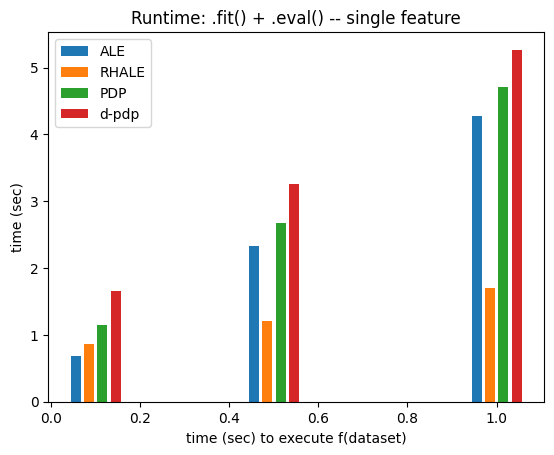

In [7]:
for metric in ["total"]:
    if metric in ["fit", "eval"]:
        title = "Runtime: ." + metric + "() -- single feature"
    else:
        title = "Runtime: .fit() + .eval() -- single feature"
    
    bar_plot(
        vec, 
        time_dict, 
        method_names,
        metric=metric,
        title=title,
        xlabel="time (sec) to execute f(dataset)",
        ylabel="time (sec)"
)

## Runtime vs. D

In [8]:
t = 0.001
N = 10_000
D = 5
K = 100
M = 100
repetitions = 2
features=[0]

In [9]:
method_names = ["ale", "rhale", "pdp", "d_pdp"]
vec = np.array([3, 4, 5, 6])
time_dict = {method_name: [] for method_name in method_names}
for D in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    for method_name in method_names:
        time_dict[method_name].append(measure_time(method_name, features))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.30s/it]


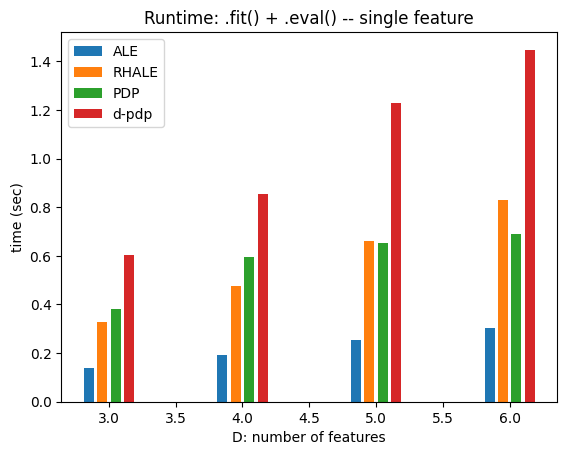

In [10]:
for metric in ["total"]:
    if metric in ["fit", "eval"]:
        title = "Runtime: ." + metric + "() -- single feature"
    else:
        title = "Runtime: .fit() + .eval() -- single feature"
    
    bar_plot(
        vec, 
        time_dict, 
        method_names,
        metric=metric,
        title=title,
        xlabel="D: number of features",
        ylabel="time (sec)"
)

## Time vs N (number of features)

In [11]:
t = 0.001
N = 100_000
D = 5
T = 100
K = 100
repetitions = 2
features=[0]

In [12]:
method_names = ["ale", "rhale", "pdp", "d_pdp"]
vec = np.array([10_000, 20_000, 30_000])
time_dict = {method_name: [] for method_name in method_names}
for N in vec:
    model = return_predict(t)
    model_jac = return_jacobian(t)
    for method_name in method_names:
        time_dict[method_name].append(measure_time(method_name, features))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]


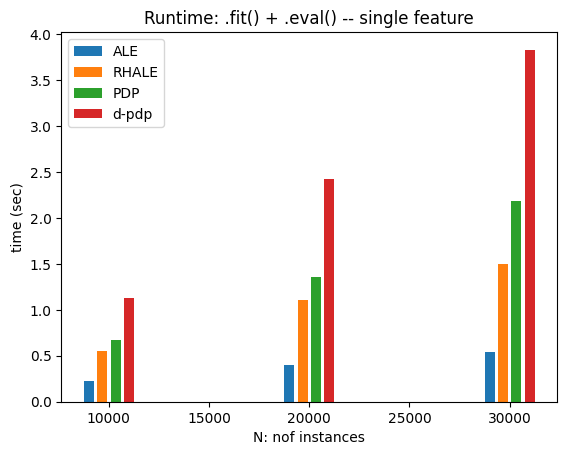

In [13]:
for metric in ["total"]:
    if metric in ["fit", "eval"]:
        title = "Runtime: ." + metric + "() -- single feature"
    else:
        title = "Runtime: .fit() + .eval() -- single feature"
    
    bar_plot(
        vec, 
        time_dict, 
        method_names,
        metric=metric,
        title=title,
        xlabel="N: nof instances",
        ylabel="time (sec)"
)

## A demanding example

In [14]:
t = 0.1
N = 50_000
D = 15
T = 100
K = 100
repetitions = 2
features=[0]

In [15]:
method_names = ["ale", "rhale", "pdp", "d_pdp"]
time_dict = {method_name: [] for method_name in method_names}
model = return_predict(t)
model_jac = return_jacobian(t)
for method_name in method_names:
    time_dict[method_name].append(measure_time(method_name, features))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.83s/it]


In [16]:
time_dict

{'ale': [{'fit': np.float64(3.3842148780822754),
   'eval': np.float64(0.2318568229675293),
   'total': np.float64(3.6160717010498047)}],
 'rhale': [{'fit': np.float64(13.92392635345459),
   'eval': np.float64(0.04656064510345459),
   'total': np.float64(13.970486998558044)}],
 'pdp': [{'fit': np.float64(11.718494892120361),
   'eval': np.float64(1.2171651124954224),
   'total': np.float64(12.935660004615784)}],
 'd_pdp': [{'fit': np.float64(23.738362908363342),
   'eval': np.float64(1.4182051420211792),
   'total': np.float64(25.15656805038452)}]}

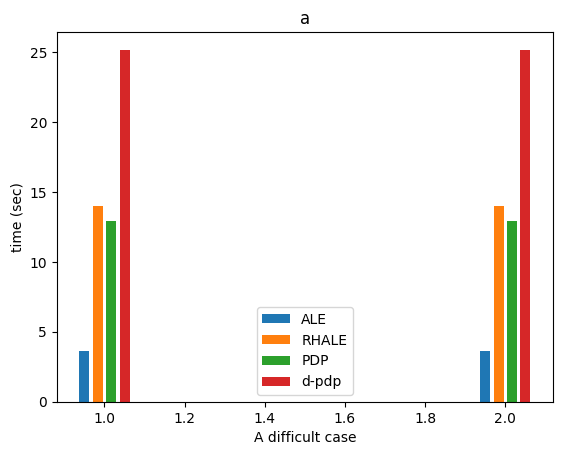

In [17]:
bar_plot(np.array([1, 2]), time_dict, method_names, metric="total", 
         title="a",
         xlabel="A difficult case",
         ylabel="time (sec)",
        )